# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Muhammad Favian Zaahir
- **Email:** favianzaahir@gmail.com
- **ID Dicoding:** MS058D5Y0648

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Data Preparation

### Data Loading

In [5]:
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test'
pred_dir = 'seg_pred/seg_pred'

### Data Preprocessing

#### Split Dataset

In [6]:
IMAGE_SIZE = (228, 228)
BATCH_SIZE = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [8]:
classes_names = train_ds.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [9]:
scenery_images = []

def getImagesPath(path):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            scenery_images.append(os.path.join(dirname, filename))
    return scenery_images

scenery_images = getImagesPath(pred_dir)
len(scenery_images)

7301

In [10]:
scenery_images = getImagesPath(train_dir)
len(scenery_images)

21335

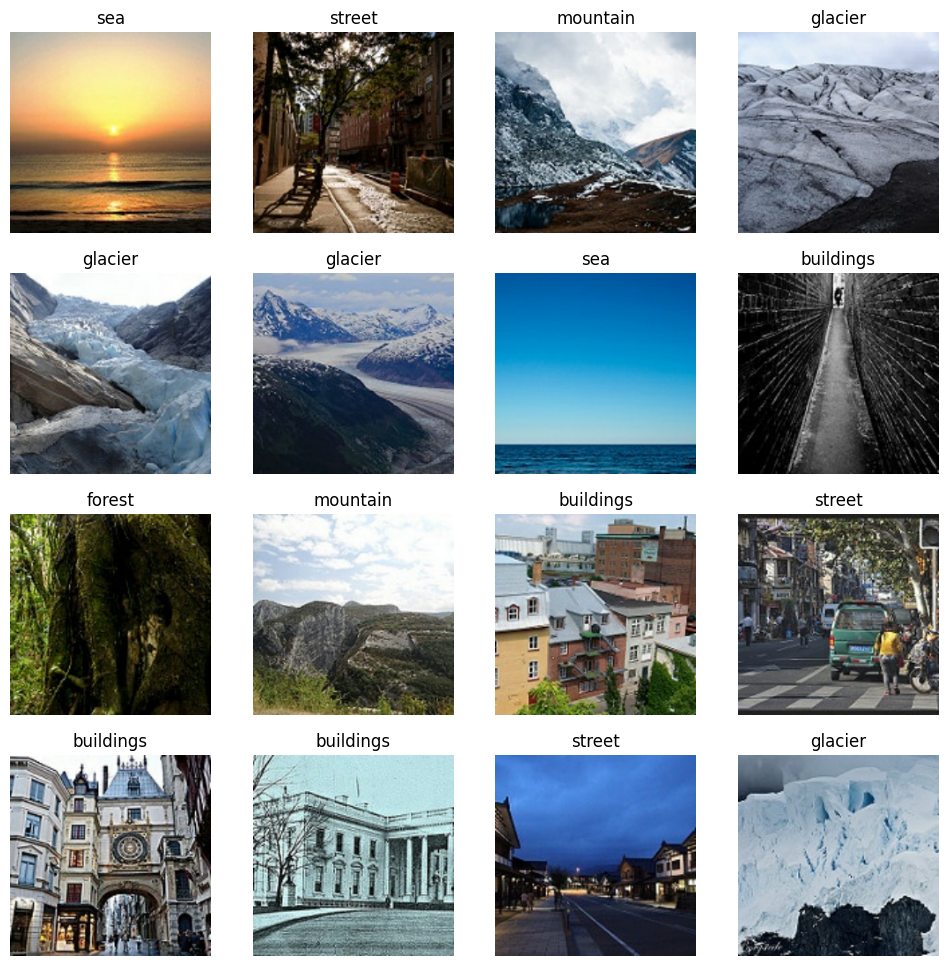

In [11]:
plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

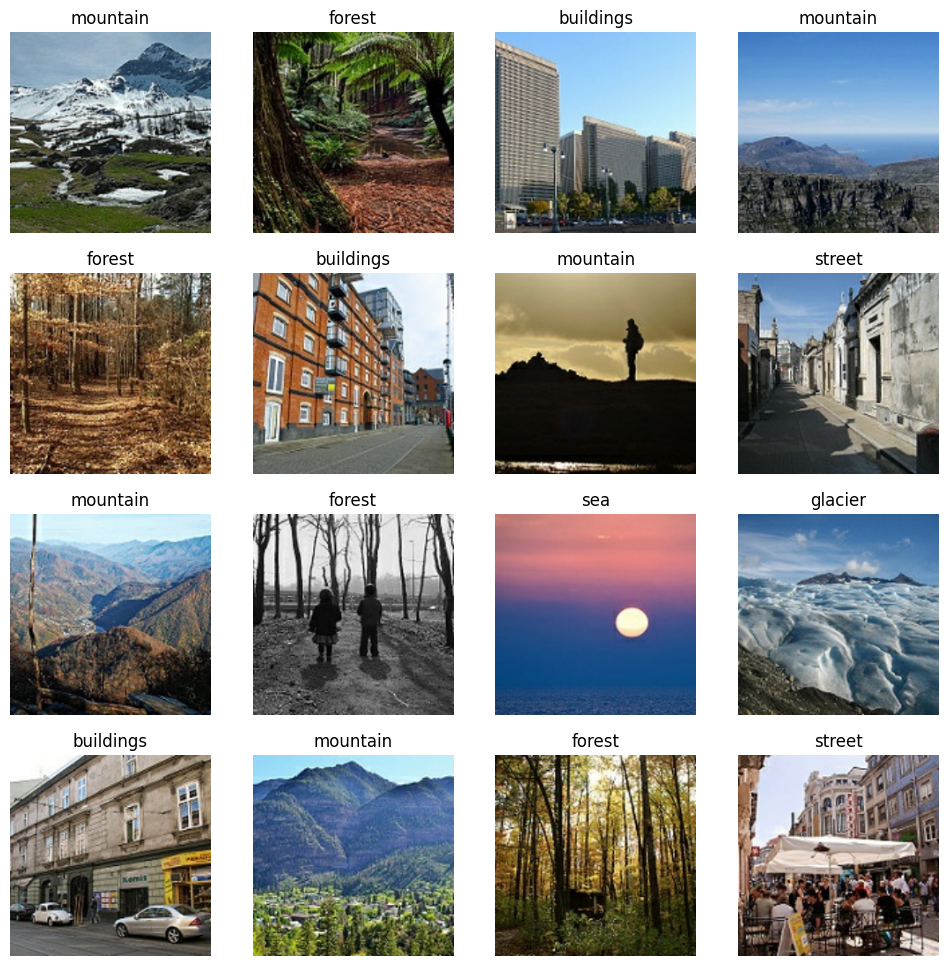

In [12]:
plt.figure(figsize=(12,12))
for images,labels in test_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

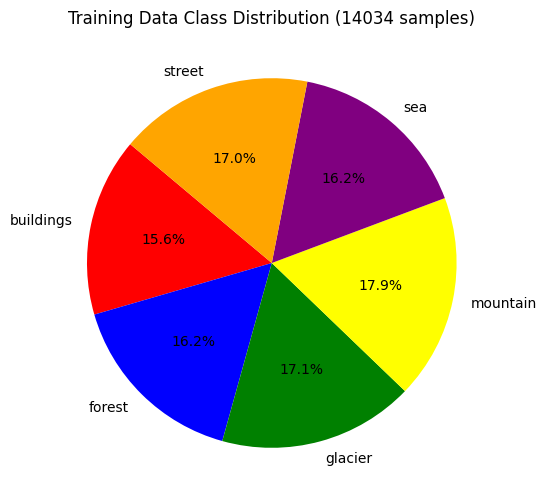

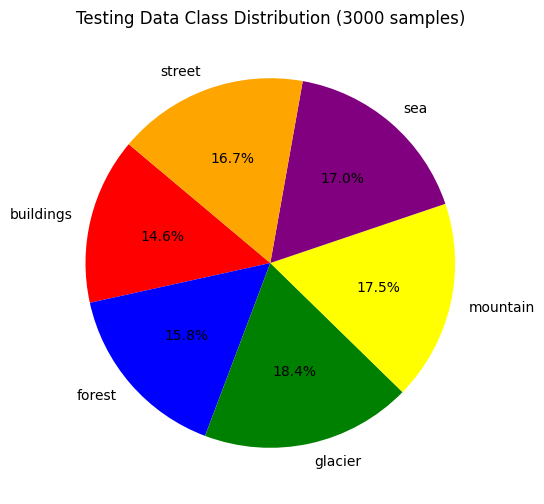

In [13]:
def get_class_counts(dataset, class_names):
    class_counts = {name: 0 for name in class_names}
    total_samples = 0
    for _, labels in dataset:
        for label in labels:
            class_counts[class_names[label.numpy()]] += 1
            total_samples += 1
    return class_counts, total_samples

train_class_counts, train_total_samples = get_class_counts(train_ds, classes_names)

plt.figure(figsize=(8, 6))
plt.pie(train_class_counts.values(),
        labels=train_class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['red', 'blue', 'green', 'yellow', 'purple', 'orange'])
plt.title(f'Training Data Class Distribution ({train_total_samples} samples)')
plt.show()

test_class_counts, test_total_samples = get_class_counts(test_ds, classes_names)

plt.figure(figsize=(8, 6))
plt.pie(test_class_counts.values(),
        labels=test_class_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['red', 'blue', 'green', 'yellow', 'purple', 'orange'])
plt.title(f'Testing Data Class Distribution ({test_total_samples} samples)')
plt.show()

## Modelling

In [14]:
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

In [15]:
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(228, 228, 3)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(classes_names), activation='softmax'))

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

def prepare_data(image, label, augment=True):
    if augment:
        image = data_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_aug = train_ds.map(lambda x, y: prepare_data(x, y, True))
test_ds = test_ds.map(lambda x, y: prepare_data(x, y, False))

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    weight_decay=1e-5
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 228, 228, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 228, 228, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 228, 228, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 228, 228, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 114, 114, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 114, 114, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 114, 114, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 114, 114, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 114, 114, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 114, 114, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 57, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,936,406 (49.35 MB)

 Trainable params: 12,935,318 (49.34 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [19]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_ds_aug,
    validation_data=test_ds,
    epochs=35,
    callbacks=callbacks
)

Epoch 1/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.4863 - loss: 1.4375
Epoch 1: val_loss improved from inf to 4.85007, saving model to best_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 319s 715ms/step - accuracy: 0.4864 - loss: 1.4370 - val_accuracy: 0.1700 - val_loss: 4.8501 - learning_rate: 0.0010
Epoch 2/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.6441 - loss: 0.9462
Epoch 2: val_loss improved from 4.85007 to 0.99933, saving model to best_model.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 312s 693ms/step - accuracy: 0.6441 - loss: 0.9461 - val_accuracy: 0.6043 - val_loss: 0.9993 - learning_rate: 0.0010
Epoch 3/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7130 - loss: 0.7854
Epoch 3: val_loss did not improve from 0.99933
439/439 ━━━━━━━━━━━━━━━━━━━━ 305s 695ms/step - accuracy: 0.7130 - loss: 0.7853 - val_accuracy: 0.6123 - val_loss: 1.1759 - learning_rate: 0.0010
Epoch 4/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.7600 - loss: 0.6729
Epoch 4: val_loss did not improve from 0.99933
439/439 ━━━━━━━━━━━━━━━━━━━━ 299s 682ms/step - accuracy: 0.7600 - loss: 0.6728 - val_accuracy: 0.4413 - val_loss: 3.4570 - learning_rate: 0.0010
Epoch 5/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7896 - loss: 0.5908
Epoch 5: val_loss did not improve from 0.99933
439/439 ━━━━━━━━━━━━━━━━━━━━ 297s 676ms/step - accuracy: 0.7896 - loss: 0.5908 - val_accuracy: 0.4353 - val_loss: 3.2584 - learning_rate: 0.0010
Epoch 6/35
439/

439/439 ━━━━━━━━━━━━━━━━━━━━ 298s 679ms/step - accuracy: 0.7901 - loss: 0.5758 - val_accuracy: 0.7670 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 7/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8379 - loss: 0.4504
Epoch 7: val_loss did not improve from 0.68055
439/439 ━━━━━━━━━━━━━━━━━━━━ 296s 673ms/step - accuracy: 0.8380 - loss: 0.4503 - val_accuracy: 0.5823 - val_loss: 1.7860 - learning_rate: 0.0010
Epoch 8/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8610 - loss: 0.3936
Epoch 8: val_loss did not improve from 0.68055
439/439 ━━━━━━━━━━━━━━━━━━━━ 291s 662ms/step - accuracy: 0.8611 - loss: 0.3935 - val_accuracy: 0.7700 - val_loss: 0.7135 - learning_rate: 0.0010
Epoch 9/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8936 - loss: 0.3013
Epoch 9: val_loss did not improve from 0.68055
439/439 ━━━━━━━━━━━━━━━━━━━━ 299s 680ms/step - accuracy: 0.8936 - loss: 0.3013 - val_accuracy: 0.7710 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 10/35
439

439/439 ━━━━━━━━━━━━━━━━━━━━ 295s 671ms/step - accuracy: 0.9678 - loss: 0.1033 - val_accuracy: 0.8227 - val_loss: 0.6457 - learning_rate: 2.0000e-04
Epoch 14/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9782 - loss: 0.0740
Epoch 14: val_loss did not improve from 0.64568
439/439 ━━━━━━━━━━━━━━━━━━━━ 296s 674ms/step - accuracy: 0.9783 - loss: 0.0739 - val_accuracy: 0.8200 - val_loss: 0.6679 - learning_rate: 2.0000e-04
Epoch 15/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9818 - loss: 0.0617
Epoch 15: val_loss did not improve from 0.64568
439/439 ━━━━━━━━━━━━━━━━━━━━ 295s 672ms/step - accuracy: 0.9818 - loss: 0.0617 - val_accuracy: 0.8257 - val_loss: 0.6771 - learning_rate: 2.0000e-04
Epoch 16/35
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9877 - loss: 0.0469
Epoch 16: val_loss did not improve from 0.64568
439/439 ━━━━━━━━━━━━━━━━━━━━ 291s 664ms/step - accuracy: 0.9877 - loss: 0.0469 - val_accuracy: 0.8047 - val_loss: 0.7779 - learning_rate: 2.00

## Evaluasi dan Visualisasi

In [20]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.8274 - loss: 0.6191
Test accuracy: 82.27%


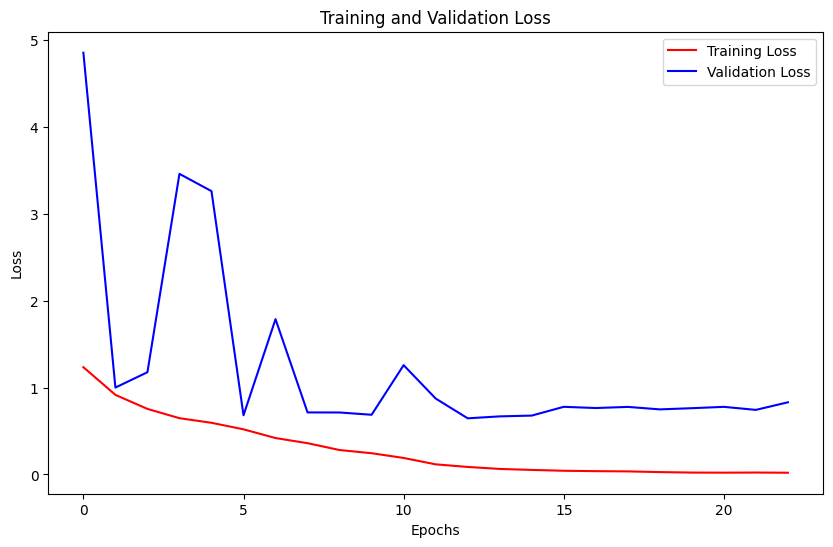

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

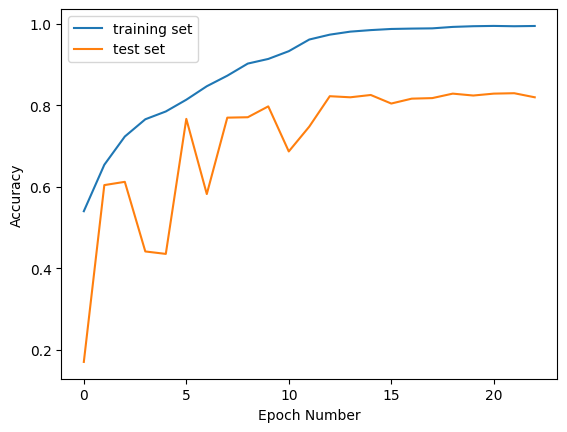

In [22]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

## Konversi Model

In [23]:
model.save('model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
uploaded = files.upload()

In [ ]:
#this was ranned in gcolab since deprecated numpy in local
import tensorflowjs as tfjs

model_path = 'best_model.h5'
model = tf.keras.models.load_model(model_path)

output_dir = 'tfjs_model'
tfjs.converters.save_keras_model(model, output_dir)
print(f"Model saved to {output_dir}")

In [ ]:
!zip -r web_model.zip web_model

files.download('tfjs_model.zip')

In [ ]:
#this was also ranned in gcolab
model_path = 'best_model.h5'
model = tf.keras.models.load_model(model_path)

classes_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

saved_model_path = 'saved_model'
tf.saved_model.save(model, saved_model_path)
print(f"Model saved to {saved_model_path}")

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TensorFlow Lite model saved to 'model.tflite'")

with open('label.txt', 'w') as f:
    for label in classes_names:
        f.write(f"{label}\n")
print("Class labels saved to 'label.txt'")

print("\nExport complete! Your model has been saved in the following formats:")
print("1. SavedModel format: saved_model/")
print("2. TensorFlow Lite: model.tflite")
print("3. Class labels: label.txt")

INFO:tensorflow:Assets written to: C:\Users\favia\AppData\Local\Temp\tmp4jv51t9u\assets


INFO:tensorflow:Assets written to: C:\Users\favia\AppData\Local\Temp\tmp4jv51t9u\assets


Saved artifact at 'C:\Users\favia\AppData\Local\Temp\tmp4jv51t9u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 228, 228, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2301234165904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301234166480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301234165136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301234167056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301234164368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301234166288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301197103568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301234167632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301377103824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2301377104400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23013

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


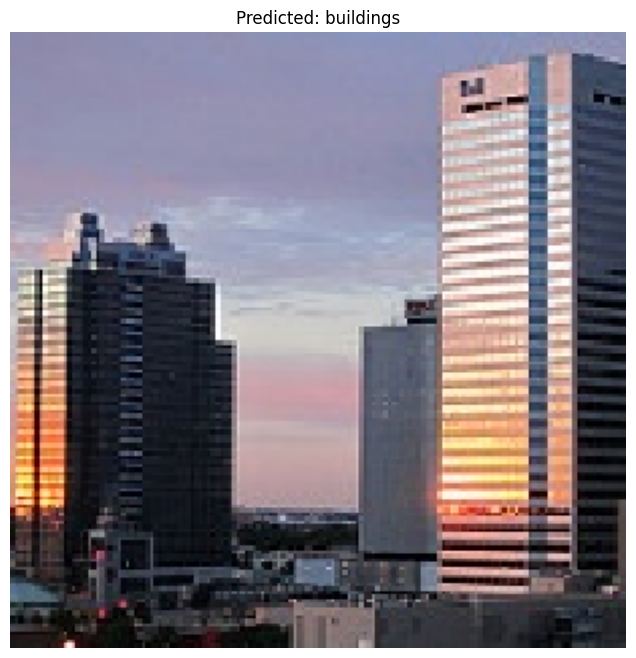

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Top 3 predictions:
buildings: 1.0000
street: 0.0000
sea: 0.0000


array([1., 0., 0., 0., 0., 0.], dtype=float32)

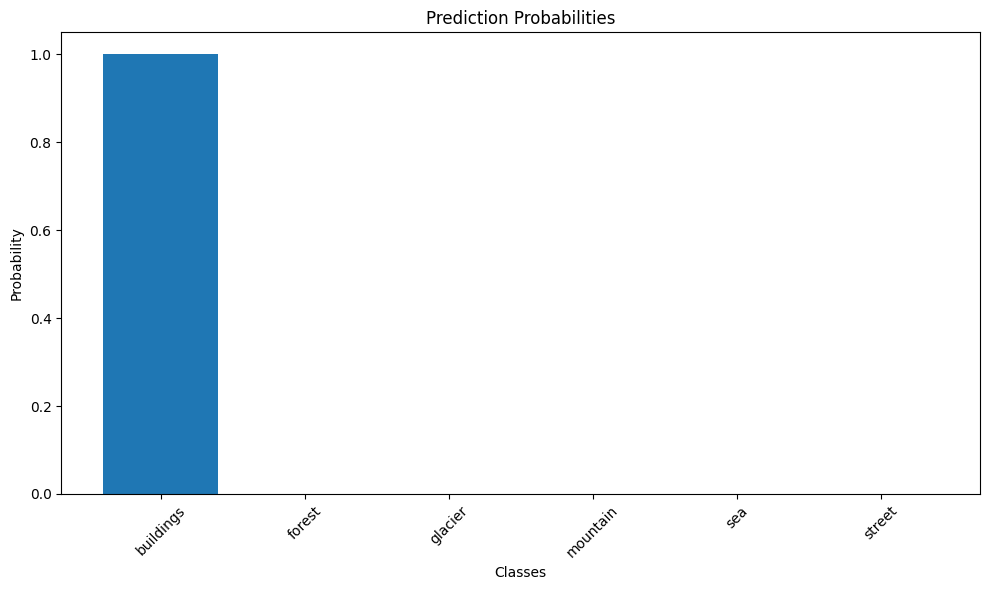

In [ ]:
def predict_img(file_name, model):
    img = image.load_img(file_name, target_size=(228, 228))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    predictions = model.predict(img_array)[0]
    predicted_class = classes_names[np.argmax(predictions)]
    
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    
    return predictions

def predict_with_probabilities(file_name, model):
    img = image.load_img(file_name, target_size=(228, 228))
    img_array = image.img_to_array(img)
    img_pro = np.expand_dims(img_array, axis=0)
    img_pro /= 255
    predictions = model.predict(img_pro)[0]

    plt.figure(figsize=(10, 6))
    plt.bar(classes_names, predictions)
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()

    top_indices = np.argsort(predictions)[::-1][:3]
    print("Top 3 predictions:")
    for i in top_indices:
        print(f"{classes_names[i]}: {predictions[i]:.4f}")

    return predictions

test_image_path = 'seg_pred/seg_pred/5.jpg'

plt.figure(figsize=(8, 8))
predict_img(test_image_path, model)
plt.show()

predict_with_probabilities(test_image_path, model)